## MultiNLI (Multi-Genre Natural Language Inference)
MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제


In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


In [3]:
import torch
from torch.utils.data import DataLoader

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 데이터셋 구성 요소

모델 학습에 필요한 '전제, 가설, 라벨' 형태로 가공한다.



*   premise (전제)
*   hypothesis (가설)
* labels (라벨)

✅ 라벨의 종류
* **함의(Entailment)**: 전제가 가설을 지 지하는 경우.​ -> 0

* **중립(Neutral)**: 전제가 가설에 대해 중립적이거나 관련이 없는 경우. -> 1

* **모순(Contradiction)**: 전제가 가설과 모순되는 경우.​ -> 2



In [4]:
import random
import pandas as pd


def load_data(path, nrows=None):
  # nrows : 최대 몇줄까지 처리할 것인지 정함
  # keep_default_na : 빈 문자열을 그대로 유지
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data


train_data = load_data(path + '/train.csv', nrows=1000)
test_data = load_data(path + '/validation_matched.csv', nrows=1000)

In [20]:
train_data[0], test_data[0]

({'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
  'hypothesis': 'Product and geography are what make cream skimming work. ',
  'label': 1},
 {'premise': 'The new rights are nice enough',
  'hypothesis': 'Everyone really likes the newest benefits ',
  'label': 1})

In [6]:
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['premise'] + row['hypothesis'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_data, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_data, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [9]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    #사전 학습한 BERT 모델
    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    #클래스 3개!
    self.classifier = nn.Linear(768, 3)

  def forward(self, x):
    #last_hidden_state : 각 토큰에 대해 의미를 담은 벡터
    #어텐션이 적용됨
    x = self.encoder(x)['last_hidden_state']
    # 맨 첫번째 CLS 토큰 뽑기
    # BERT에서는 [CLS]가 이 문장이 전체적인 의미를 요약해서 담은 대표 벡터이다.
    x = self.classifier(x[:, 0])

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [11]:
for param in model.encoder.parameters():
  param.requires_grad = False

FREEZE!!

In [12]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

train_accs = []
test_accs = []

In [22]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 50
train_losses = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # avg_loss = total_loss / len(train_loader)
  # train_losses.append(avg_loss)

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 15.709599077701569
=========> Train acc: 0.528 | Test acc: 0.396
Epoch   1 | Train Loss: 15.843812882900238
=========> Train acc: 0.559 | Test acc: 0.405
Epoch   2 | Train Loss: 15.834752023220062
=========> Train acc: 0.566 | Test acc: 0.413
Epoch   3 | Train Loss: 15.74386864900589
=========> Train acc: 0.537 | Test acc: 0.400
Epoch   4 | Train Loss: 15.5946586728096
=========> Train acc: 0.567 | Test acc: 0.406
Epoch   5 | Train Loss: 15.56369400024414
=========> Train acc: 0.570 | Test acc: 0.400
Epoch   6 | Train Loss: 15.444568037986755
=========> Train acc: 0.559 | Test acc: 0.409
Epoch   7 | Train Loss: 15.416470646858215
=========> Train acc: 0.551 | Test acc: 0.403
Epoch   8 | Train Loss: 15.480739772319794
=========> Train acc: 0.529 | Test acc: 0.385
Epoch   9 | Train Loss: 15.43199634552002
=========> Train acc: 0.588 | Test acc: 0.415
Epoch  10 | Train Loss: 15.334840416908264
=========> Train acc: 0.533 | Test acc: 0.405
Epoch  11 | Train Loss: 15

## 사전학습 BERT 정확도 비교

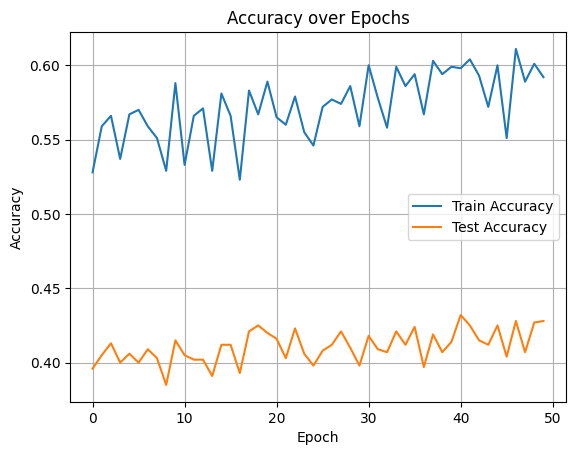

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

사전학습 BERT 샘플 테스트

In [28]:

from torch.nn.functional import softmax
index = 5
# 테스트 샘플 하나 꺼내기
sample = test_data[index]

#라벨
label_map = {
    0: "entailment(지지)",
    1: "neutral(중립)",
    2: "contradiction(모순)"
}


premise = sample['premise']
hypothesis = sample['hypothesis']
true_label = sample['label']

encoded = tokenizer(premise, hypothesis, return_tensors='pt', truncation=True, padding=True, max_length=256)
input_ids = encoded['input_ids'].to('cuda')
attention_mask = encoded['attention_mask'].to('cuda')

# 예측
model.eval()
with torch.no_grad():
    logits = model(input_ids)
    pred_class = logits.argmax(dim=-1).item()  # 예측 클래스 인덱스
    # softmax로 확률 분포 체크
    probs = softmax(logits, dim=-1)[0].tolist()


# 출력
print("🟦 전제:")
print(premise)
print("\n🟦 가설:")
print(hypothesis)
print("\n🟩 정답 라벨:", f"{true_label} ({label_map.get(true_label)})")
print("🟥 예측 라벨:", f"{pred_class} ({label_map.get(pred_class)})")

print("\n📊 예측 확률 분포:")
for i, prob in enumerate(probs):
    print(f"  {label_map.get(i)}: {prob:.3f}")

🟦 전제:
well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be

🟦 가설:
We have plenty of space in the landfill.

🟩 정답 라벨: 2 (contradiction(모순))
🟥 예측 라벨: 2 (contradiction(모순))

📊 예측 확률 분포:
  entailment(지지): 0.123
  neutral(중립): 0.238
  contradiction(모순): 0.638
